## Obtaining light curves for RR Lyrae stars in the PAL5 globular cluster

This notebook builds on the previous work of obtaining lightcurves for stars within the Palomar 5 globular cluster by refining the PSF photometry. This will be done by using the master mosaic image for the ePSF model and to build a source list using it due to its lower signal-to-noise ratio (SNR).

The aim is the compare each epoch to the master source list instead of epoch 1 as in the previous notebook and creating a consistent unique ID corresponding to each star across the epochs to make matching the stars easier. Failing this, then converting the sky coordinates into planar x, y coordinates for each epoch and using the master image to find the nearest star.

This will hopefully mean that light curves can be built with slighter higher accuracy by improving the photometry and also reducing the possibility of matching the stars between epochs incorrectly. A brief analysis to ensure there is no systematic error between epochs will be carried out and an attempt to find the standard deviation of stars detected and matched will be done and plotted to identify perhaps stars that vary (will have standard deviations errant compared to the rest of the stellar population).

The next phase in a different notebook is to create a master notebook and begin the process of folding the lightcurves to aid in identifying the periods of the RR Lyrae stars and so calculate their distances.

Contents:

1) list of imports

2) PSF Photometry: -ePSF model using mosaic image; -create master star list -PSF photometry using fixed centroids from the mosaic image on each epoch, saving the data in the filename format: PAL5_PSFphot_02_epochxx_channelxpxum.fits

3) Star matching: -convert both master and epoch coordinates into right ascension and declination values -match the stars between the two lists -copy star ID from master list to epoch list -join the tables together based on the master ID -loop for all epochs

4) Extract magnitudes and errors: -extract the magnitudes and errors for each suspected RRL and some random stars -systematic error analysis from random stars

5) Analysis: -calculate standard deviations and plot -investigate errant stars (could be RRLs)

6) Light curves: -plot and save all the lightcurves

7) Next steps: -prepare to extend lightcurves, fold them and find their periods

In [1]:
import math
import glob
import copy
import numpy as np
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

%matplotlib inline

#### Building ePSF model using master mosaic image

FITS file information:
FILE = PAL5_data/PAL5__e1/PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1257
EXPTIME = 71.3724




Number of ePSF sources found = 52



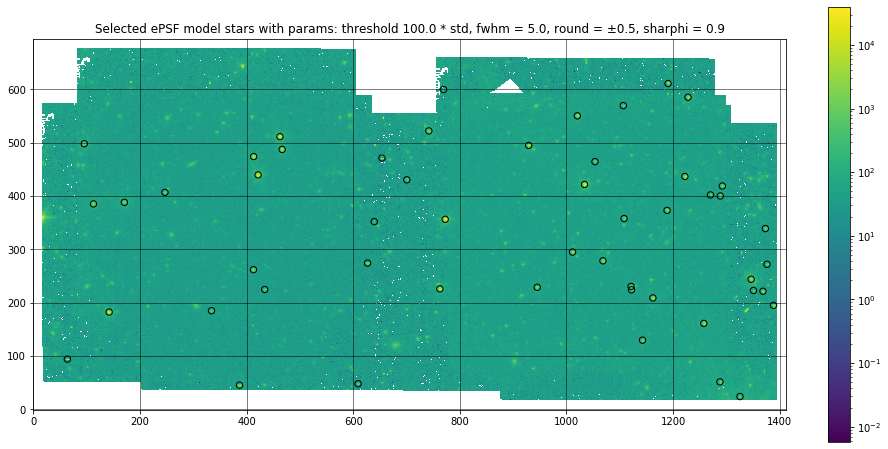

Number of refined ePSF sources = 38



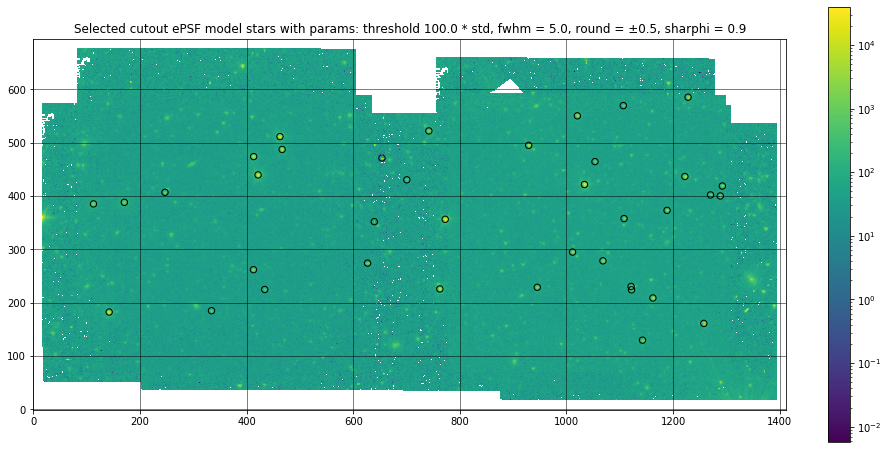

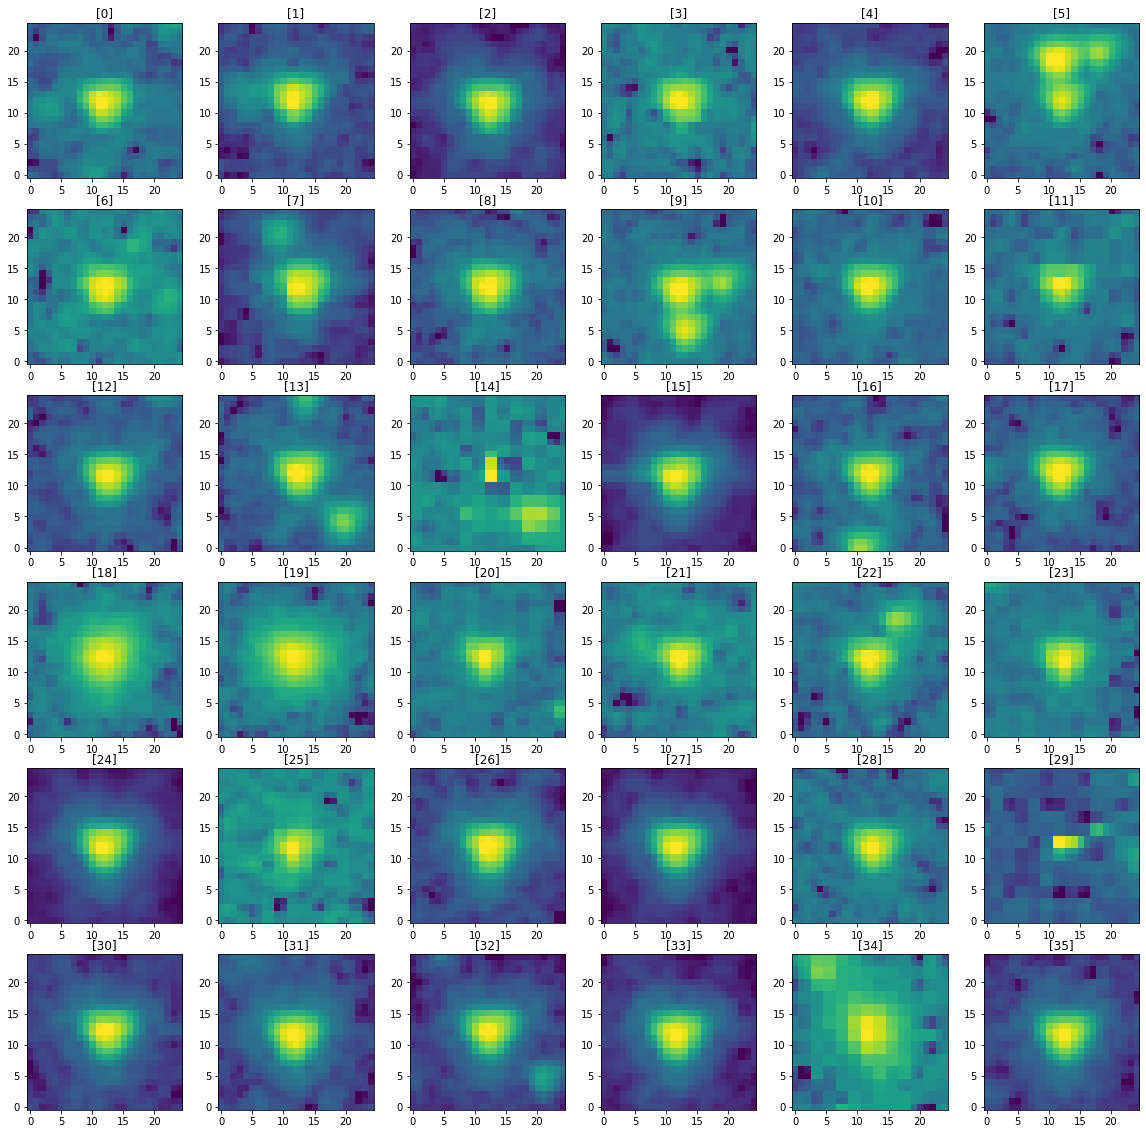

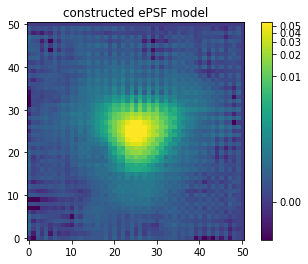

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
34 29 5 9 14


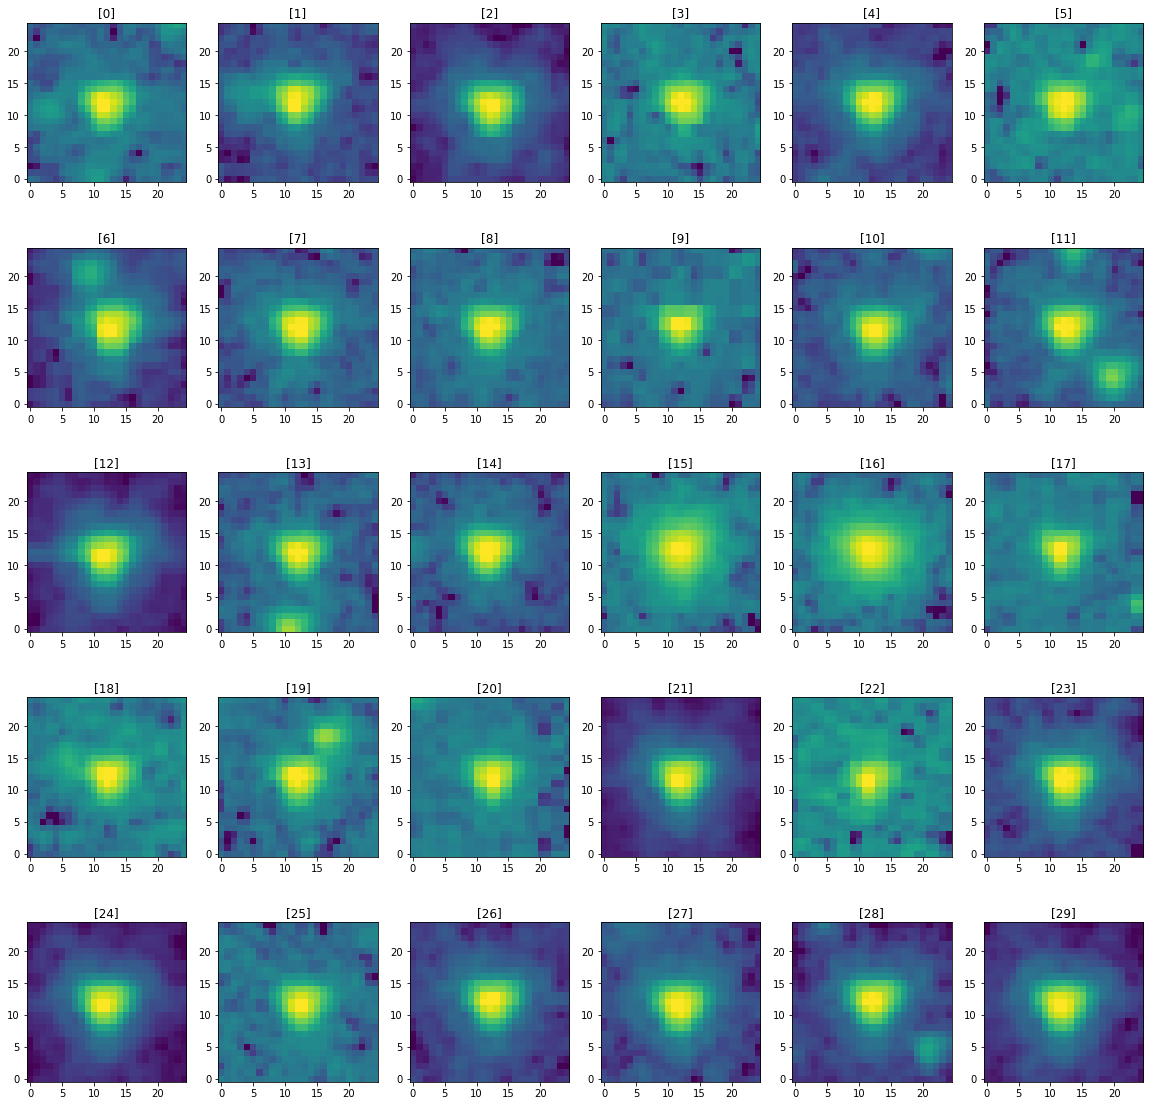

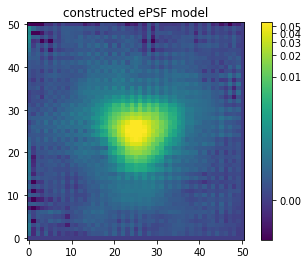

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



In [2]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
general_dir = 'PAL5_data/'
channel = '3p6um'

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 
    
#____________________________________#
## BUILD ePSF MODEL USING ONE IMAGE ##

epoch_dir = 'PAL5_data/PAL5__e1/'  # specific epoch for ePSF
master_dir = 'PAL5_data/PAL5/'     # mosaic image for ePSF

epsf_file = epoch_dir+'PAL5__e1_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(epsf_file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    time = Time(header['DATE_OBS'])
    counts = exptime / fluxconv
    image_data = fits.getdata(epsf_file, ext = 0)
    data = image_data * counts
    print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(epsf_file, time, fluxconv, exptime))

## PARAMETERS : ePSF ##

fwhm = 5.
sigma_val = 6.
model_threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.9
do_plot = True

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

if do_plot == True:
    # PLOT SELECTED STARS TO TEST PARAMETERS #
    positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()

elif do_plot == False:
    pass

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_tbl = Table()      # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

if do_plot == True:
    # PLOT CUTOUT STARS TO BE USED IN EPSF MODEL #
    cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
    cutout_apers = CircularAperture(cutout_pos, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    cutout_apers.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected cutout ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
elif do_plot == False:
    pass

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
epsf_data = data - median_val

while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

#### Building master star list from mosaic image and converting into (α, δ)

FITS file information:
FILE = PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054




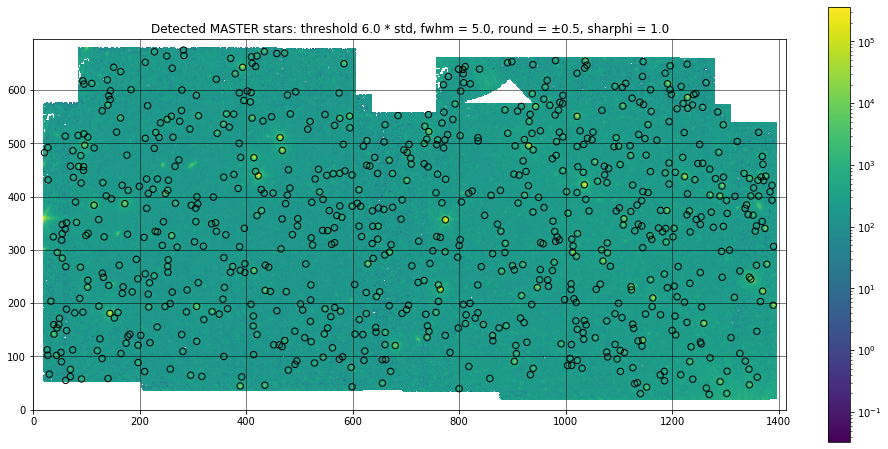

Number of MASTER stars detected = 792

master_id        x_0         ...         ra                  dec          
--------- ------------------ ... ------------------ ----------------------
        1 1269.5063258483376 ...  229.0630315162843   -0.15644268282020193
        2 1140.2739672278392 ...  229.0662732722692    -0.1351476171842811
        3 1302.5323577023107 ... 229.06184132896902    -0.1618256156510142
        4   799.686317494766 ... 229.07389270435505    -0.0788740231578068
        5 1264.2161506278433 ...  229.0612170509874   -0.15525266063353485
        6 1152.0517082774918 ... 229.06392773476134    -0.1367532412693178
        7  598.6735177125719 ...  229.0787177354827    -0.0457152943064213
        8  388.5643966406068 ... 229.08411544976045  -0.011113989482135852
        9  434.8194022933505 ... 229.08262817827094  -0.018682504779313835
       10 1344.9425064804868 ...  229.0580442428365    -0.1683672050048424
      ...                ... ...                ...          

In [6]:
## BUILD MASTER STAR LIST USING MOSAIC ##

master_dir = 'PAL5_data/PAL5/'  # mosaic image for ePSF

master_file = master_dir+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as header_list:
    master_header = header_list[0].header
    fluxconv = master_header['FLUXCONV']
    exptime = master_header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(master_file, ext = 0)
    master_data = image_data * counts
    print('FITS file information:\nFILE = {0}\nFLUXCONV = {1}\nEXPTIME = {2}\n\n'.format(master_file, fluxconv, exptime))

## PARAMETERS FOR USE ON MASTER IMAGE ##

sigma_master = 6.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## SOURCE DETECTION ON MASTER IMAGE ##

mean, median, std = sigma_clipped_stats(master_data, sigma = sigma_val)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_master * std, roundlo = roundlo, roundhi = roundhi)
master_sources = master_daofind(master_data)

master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = 6.)

plt.imshow(master_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma_master, fwhm, roundhi, sharphi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))
    
## RENAMING STAR LIST TITLES ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## CONVERT COORDINATES ##

w = wcs.WCS(master_header)
coord = np.transpose((master_sources['x_0'], master_sources['y_0']))
world = w.wcs_pix2world(coord, 0)

m_ra, m_dec = world[:, 0], world[:, 1]
m_c = SkyCoord(m_ra, m_dec, frame = 'icrs', unit = 'deg')

master_sources['ra'] = m_ra
master_sources['dec'] = m_dec

## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##

master_sources['master_id', 'x_0', 'y_0', 'ra', 'dec'].write(
    r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFmaster_02_channel{0}.txt'.format(channel), format = 'csv', overwrite = True)
    
print(master_sources['master_id', 'x_0', 'y_0', 'ra', 'dec'])
print('\n\n')

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1257
EXPTIME = 71.3724




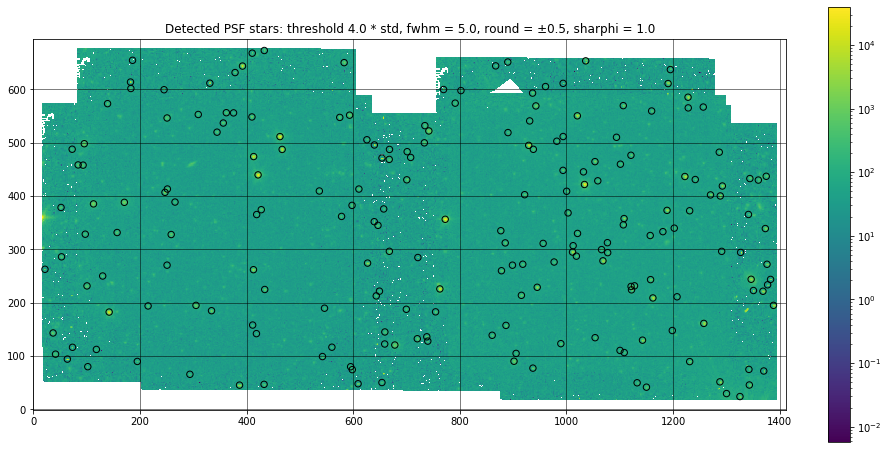

Number of stars detected = 208



Number of PSF stars found and analysed = 833

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.5782204800735 ... 16.884680260869878 0.038150749111372714
  5 1262.3134422773646 ... 17.576676726628037 0.061517397453705276
  2 1138.3505633021236 ... 17.318620980171602  0.06516458511330206
  6 1150.1544127823045 ... 15.412377901397589 0.026637613725703824
 11 1127.6586310929752 ... 17.512543162967233  0.07702290877572199
 13 1132.7218762498342 ... 16.421567236924776 0.036292711507417925
  3 1300.6077332762939 ... 16.376219746802114  0.05304707272741713
  4  797.7872658002979 ... 16.899983624438416  0.03938809063127949
  7  596.7845916133225 ... 16.964302161349732 0.037141278219401025
  8 386.68146760906023 ... 14.085519281673838 0.030004518315152384
...                ... ...                ...                  ...
 31   639.686164760881 ... 13.224652822846267  0.04543446541490729
 32 245.18095832

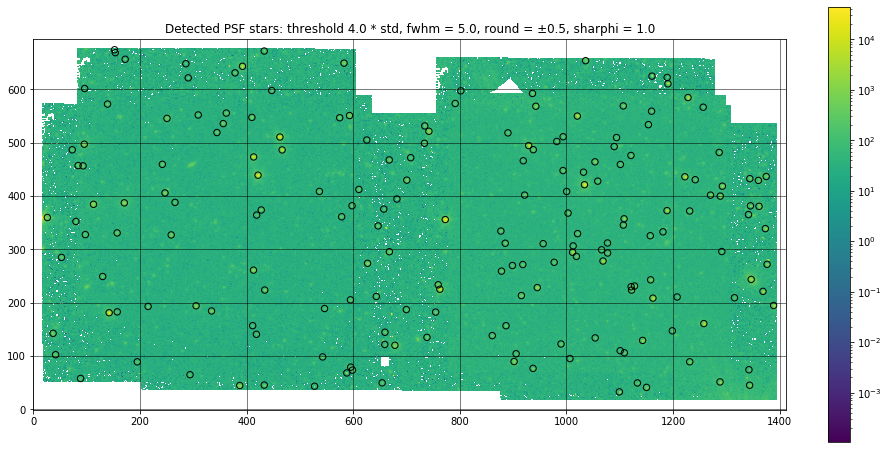

Number of stars detected = 192



Number of PSF stars found and analysed = 816

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.7948608295528 ... 17.022475243856192  0.04424521242762445
  5  1262.523837823153 ... 17.463622715135813  0.05921819762015924
  2 1138.5569139438476 ...  17.17195068567215  0.06512625266749071
  6 1150.3555697567776 ...  15.43291955770816 0.027061057927711525
 11 1127.8549955337967 ... 17.468860819654157   0.0858271674318596
 13 1132.9176722201532 ...  16.29210009160179  0.03719903708739556
  3 1300.8259213288497 ...  16.36811450670831   0.0551209881451738
  4  797.9637344593594 ... 16.900408335316104 0.036743250510033736
  7  596.9444053742786 ...  16.88498000356689 0.040841929093007566
  8 386.82493257615016 ... 14.219996875101033 0.031043277952317778
...                ... ...                ...                  ...
 14  242.0054423423318 ...  15.98414686887352   0.0336170993821739
 15  447.2427564

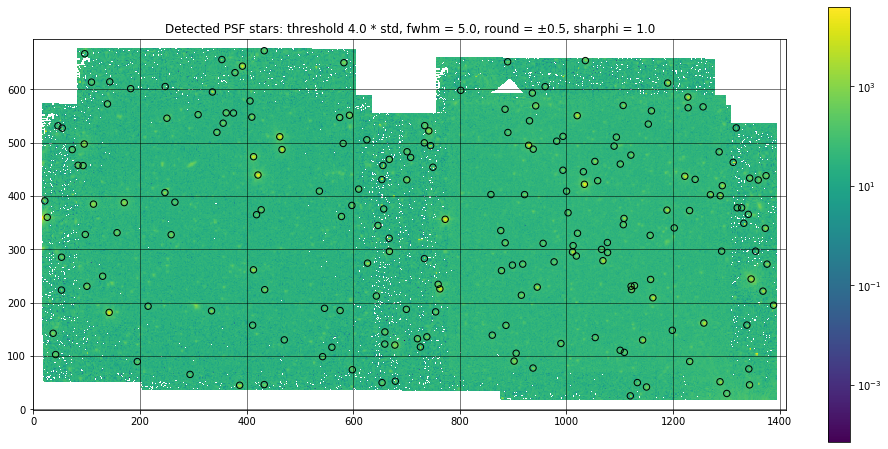

Number of stars detected = 207



Number of PSF stars found and analysed = 835

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.7571724523252 ...  17.06890367980324  0.04667660900523115
  5  1262.482529665871 ...   17.4750720140794  0.06299211987411368
  2 1138.5250857349447 ... 17.212333340607273  0.07010148998164807
  6 1150.3191437802877 ... 15.445884321004499  0.02753532037863717
 11 1127.8176017974351 ... 17.443600259517833   0.0869019721413522
 13  1132.879405328589 ... 16.394366206512434  0.04006230005262203
  3 1300.7860183171606 ... 16.257658843730727  0.04514720255012558
  4  797.9455187875515 ...  16.83648689959139 0.036408584178084284
  7  596.9348740913653 ...  16.85498582369245  0.04037247534454071
  8 386.82518105582767 ...  14.09543868794021 0.028602270540295023
...                ... ...                ...                  ...
 34  46.21976740659161 ... 17.136209971094427  0.07270051389973398
 33 1318.4047975

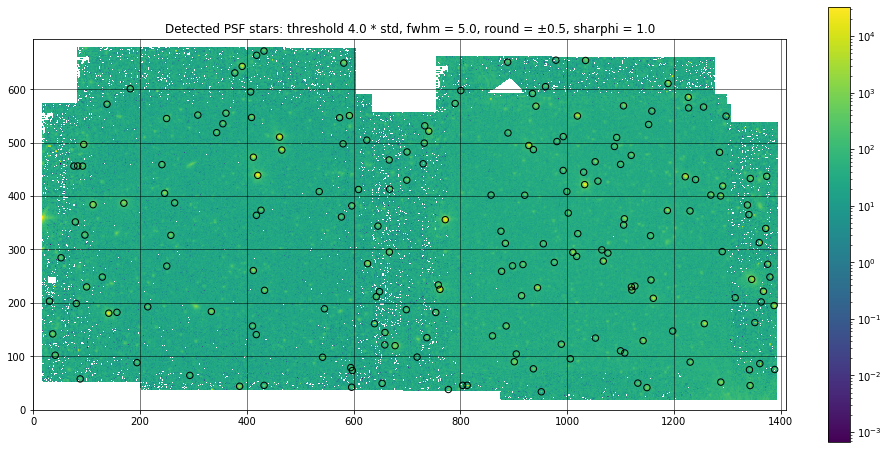

Number of stars detected = 197



Number of PSF stars found and analysed = 820

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1266.9815435877595 ... 17.022812581410744  0.04576818432620806
  5 1261.7017149066537 ...  17.42391438869911  0.05858908969237148
  2 1137.7431732836935 ... 17.088626896167266  0.07263731422430392
  6 1149.5326147825022 ... 15.487276050405992 0.028612014097657137
 11 1127.0274391050075 ...  17.43184512648161  0.10176454877317806
 13  1132.088666592741 ... 16.169257492626205  0.03921365114192562
  3  1300.011079624408 ...  16.28142219940807 0.054535121307477355
  4  797.1447070696419 ... 16.869535323820664   0.0421728850463719
  7  596.1237386161243 ... 16.806171269923713  0.04017173494197468
  8  386.0041515697976 ... 14.190580634091505  0.02949942349077242
...                ... ...                ...                  ...
 18  1359.723346536595 ... 12.845930413995266 0.040375784267673416
 19  667.4261231

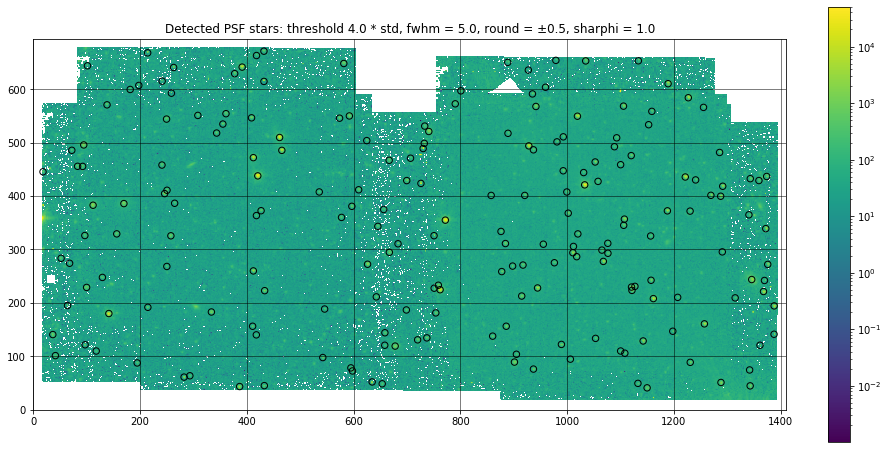

Number of stars detected = 203



Number of PSF stars found and analysed = 833

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.1741027339526 ...  17.23991259059991  0.04969769135206745
  5 1261.8900969686247 ... 17.390095873590738  0.05583819236943319
  2 1137.9322526885594 ... 17.326438674027397  0.08613787697121306
  6 1149.7177634026648 ... 15.486669619107646  0.02840341567848777
 11  1127.209903003226 ... 17.670663860922275  0.11271945214036198
 13 1132.2705937943829 ...  16.26601897500162 0.038752071022485124
  3 1300.2037784952045 ...  16.22090532905232  0.05412107329067739
  4    797.32270094652 ...  16.90586687070479  0.04608176200763082
  7  596.2958697137069 ...  16.83663398278464  0.03650546665417051
  8  386.1708888081759 ... 13.935135622299107 0.027743385501605173
...                ... ...                ...                  ...
 31 241.27300106454922 ...   16.5692712764668 0.041555774961795855
 32  431.9563295

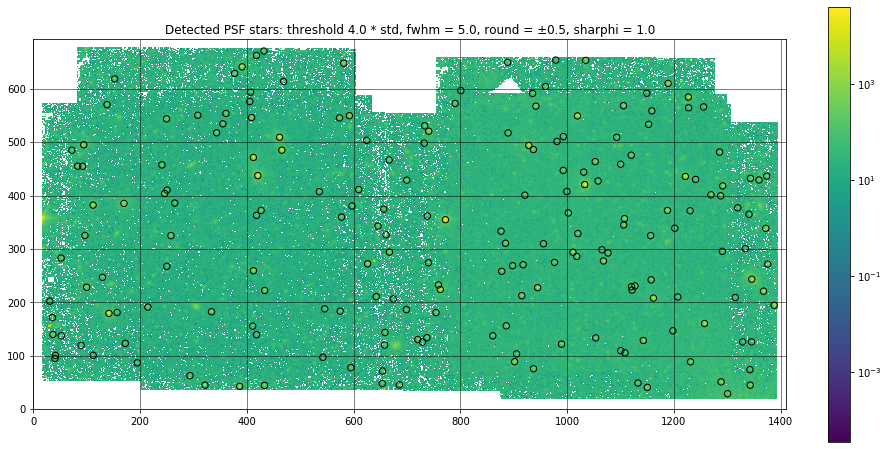

Number of stars detected = 198



Number of PSF stars found and analysed = 829

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.4113449337437 ...  17.04878813644135  0.04574704143046257
  5   1262.12173675846 ... 17.399661473168273 0.060855296713677884
  2  1138.169940088273 ... 17.110029648488972  0.06916490469972533
  6  1149.949492481583 ... 15.439836236108544  0.02825902451031015
 11 1127.4388139077823 ... 17.591958842985132  0.10418331983609479
 13 1132.4985498255073 ... 16.207742280672857 0.037175736194928505
  3  1300.439862738602 ...  16.22008639239351  0.04988608982110681
  4  797.5588941814709 ... 16.959068401381664 0.043436570301073625
  7  596.5321281734375 ... 16.890422136983055 0.034061754248075025
  8  386.4082382893662 ... 13.933893395572255 0.028446272723921997
...                ... ...                ...                  ...
 27  618.0085362709546 ...  16.48063256153689  0.04853867846094087
 28   1149.03934

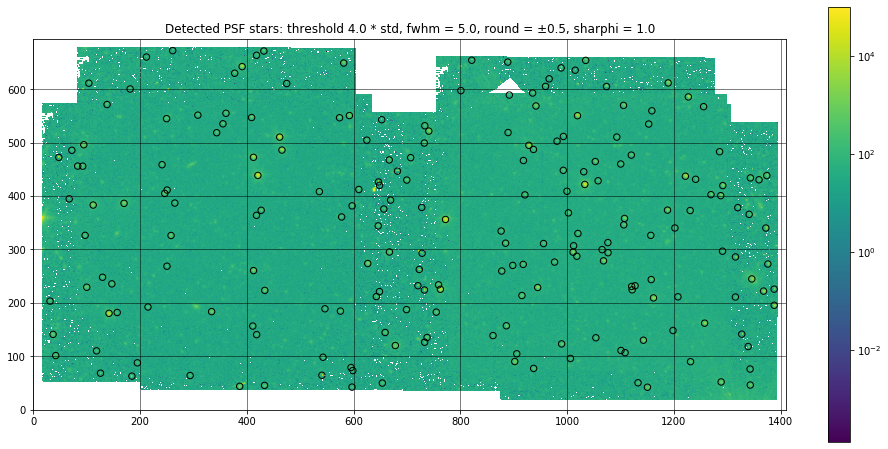

Number of stars detected = 211



Number of PSF stars found and analysed = 847

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.6543611945506 ... 17.120340748483265  0.04376064665031123
  5 1262.3616294461708 ... 17.591928105004662 0.061927717619623915
  2 1138.4098266977383 ... 17.257608519973758  0.06820257117841952
  6  1150.186510512692 ... 15.417729302090233 0.027084908015894204
 11  1127.673743574999 ...  17.74823238701674   0.1031581101600863
 13 1132.7331024116859 ... 16.269031675732386  0.03549421240124106
  3 1300.6831223120969 ...  16.01073663974592  0.08058972452858973
  4  797.7891110939864 ...  16.91354152107215  0.04368540245734253
  7  596.7571428207735 ...  16.88478344775115   0.0382258145786979
  8  386.6283603711276 ... 14.005082750665323  0.06826105200495963
...                ... ...                ...                  ...
 45  988.5154792642176 ... 13.741409658276204 0.047430525211386916
 46     821.1946

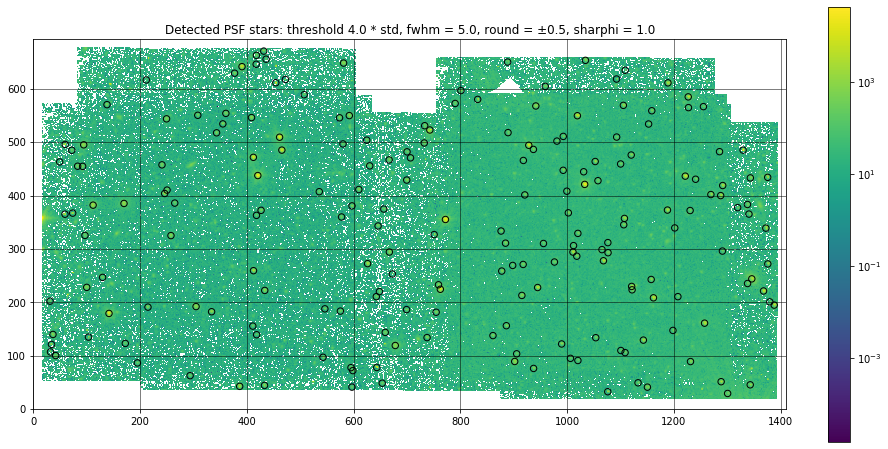

Number of stars detected = 203



Number of PSF stars found and analysed = 827

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.6355588257416 ... 16.980308530855776  0.04496923299486351
  5  1262.339816647002 ...  17.26581971614814  0.05552934214954796
  2 1138.3916897541503 ... 17.004050552771957  0.06016719889881379
  6 1150.1651146806153 ... 15.414581663217952  0.02741885213813434
 11  1127.650898655912 ...  17.63410905069095  0.09944009647070154
 13 1132.7097248007417 ... 16.049475771849835  0.03317454287186492
  3 1300.6635855618638 ... 16.015125559822504  0.04080645138578383
  4  797.7712862211206 ... 17.026553651993012  0.04661701042154556
  7  596.7400139748546 ...  16.74416747016554  0.03158943903216878
  8  386.6125118453377 ... 13.922276729587386  0.02981737995258472
...                ... ...                ...                  ...
 25  832.3056239235599 ...  14.06072082849678  0.04329763476256103
 26  507.2943722

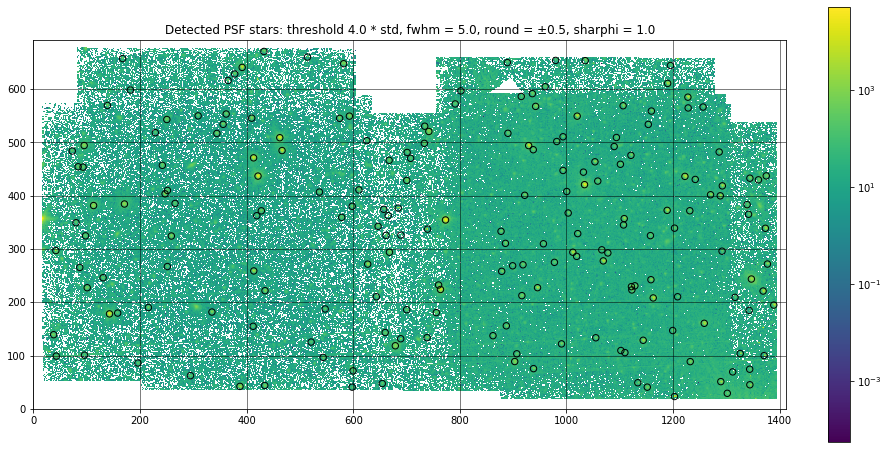

Number of stars detected = 197



Number of PSF stars found and analysed = 820

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1268.9079851616107 ... 16.947145725401338   0.0485766741043601
  5 1263.6058546498657 ...  17.08778838996702  0.05338050820255908
  2 1139.6521900913049 ...   17.0404505062426  0.05969742951658502
  6 1151.4204898823068 ... 15.421798213864607  0.02719173741080178
 11 1128.9011568794936 ... 17.516328937292187  0.09100317209417406
 13 1133.9594658447986 ... 16.069453196986096 0.033733704183640065
  3 1301.9379635431837 ... 16.088635155746317 0.045483639372430384
  4  798.9975558561697 ...  16.86327059999746 0.040063467598679306
  7  597.9470750216395 ...  16.44493003402004  0.03218615908608961
  8  387.8005687774406 ... 13.939809510591731  0.02800060343277309
...                ... ...                ...                  ...
 18  665.5803470556607 ... 14.631462025449657  0.05324138115906659
 19  684.3364053

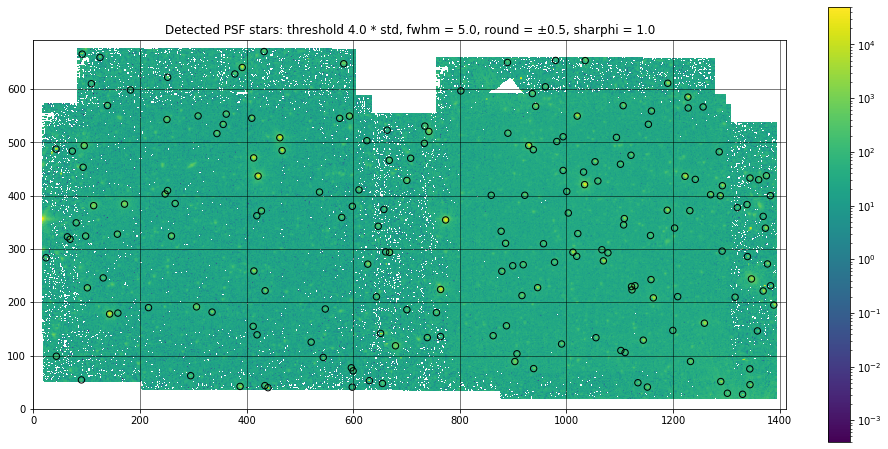

Number of stars detected = 193



Number of PSF stars found and analysed = 823

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1269.1753731540516 ...  16.78720407188157  0.03714710872886283
  5 1263.8693508972137 ... 17.410701540602798  0.05549597994133864
  2  1139.927320670049 ... 16.984148356065504 0.051204711778858165
  6 1151.6904836648932 ... 15.364750833415895 0.026201525585316115
 11 1129.1703309657983 ... 17.402544993975482  0.06922571501037823
 13 1134.2276348702976 ... 16.142614840365184  0.03168903480611585
  3 1302.2025909987474 ... 16.228136938429767  0.05131084279401481
  4  799.2910943817374 ...  16.99231607304844  0.04529298153934959
  7   598.252186968313 ...  16.68606564250046 0.035484834222804046
  8  388.1185437699434 ... 13.973483367403748 0.030142355266457706
...                ... ...                ...                  ...
 21 1393.2842794340945 ...  16.03549026137003 0.050223902335572564
 22 18.643310711

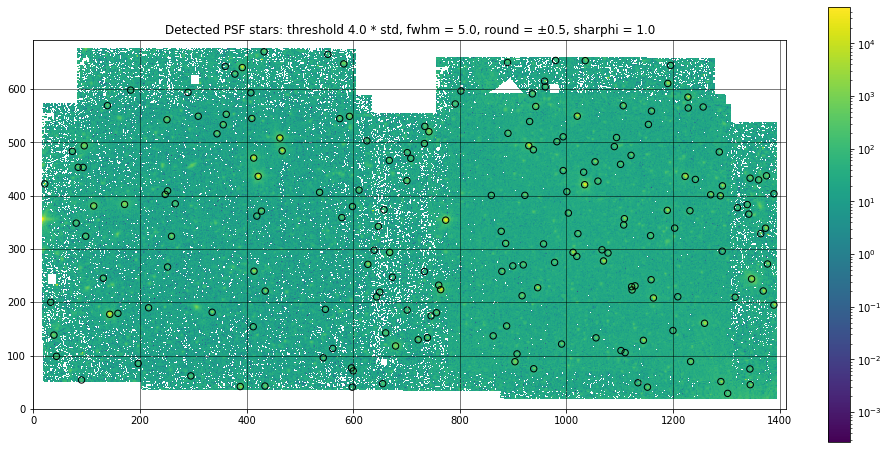

Number of stars detected = 196



Number of PSF stars found and analysed = 815

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1269.4089034480435 ... 16.765329469504287 0.038217076057393634
  5 1264.0990251960293 ...  17.33307833915992  0.05630649661773378
  2 1140.1562013698963 ... 17.040767036532472   0.0573151869236557
  6 1151.9159286778745 ... 15.361279950636789 0.026832503605648886
 11  1129.393077587902 ...  17.29065379195479  0.07005344360282197
 13  1134.449952133923 ... 16.306347542615473 0.035832392532090925
  3 1302.4366285270107 ... 16.230214793806173  0.04940299991636246
  4  799.5059815563274 ... 16.828873016728803  0.03817926527741151
  7  598.4594329085938 ...   16.6749001460387 0.036963666350464115
  8  388.3184697699192 ... 14.225102354273272  0.03141030317977313
...                ... ...                ...                  ...
 13 1364.4355370241947 ... 14.400451424096271 0.042095087955494236
 14  1320.794225

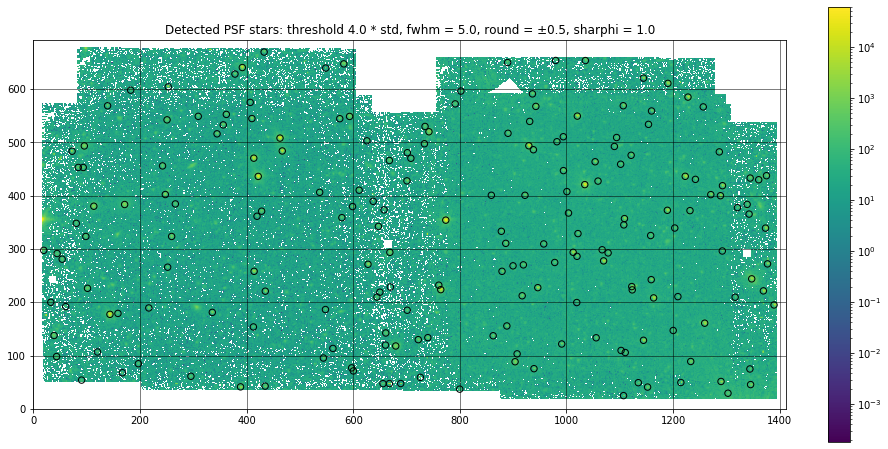

Number of stars detected = 197



Number of PSF stars found and analysed = 825

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1269.7341197089133 ... 16.919977616073094  0.04036891880017461
  5 1264.4193549582021 ... 17.399740721073847  0.05602412215448235
  2 1140.4854061286082 ...  17.17827527807592  0.06593623955892705
  6 1152.2394532347676 ... 15.397669702360757 0.027327223191483754
 11  1129.714695245567 ...  17.26695184888795  0.07319102831504373
 13 1134.7705714165588 ... 16.349511948345103  0.03846625677788147
  3 1302.7598873758834 ... 16.204258277355432  0.05334721408071891
  4  799.8433013204934 ... 16.582585076393407 0.035152623001216375
  7  598.8023929822468 ... 16.765540689459723  0.03330332448975833
  8  388.6682443497443 ... 14.290001516313994  0.03121752959590902
...                ... ...                ...                  ...
 23 1229.9817634173314 ...  16.16291276398736  0.15164412315834852
 24 253.00854576

In [8]:
## PSF PHOTOMETRY ON ALL EPOCHS ##

## PARAMETERS ##

sigma_psf = 4.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## EPOCH LOOP COUNTER ##

epoch = 0

## COPY MASTER TABLE AS MAIN TABLE ##

main_table = copy.copy(master_sources)

## STORING EPOCH TIMES AS MODIFIED JULIAN DATE VALUES ## #could refine/update later?

epoch_time = []

## PSF PHOTOMETRY LOOP ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        time = Time(header['DATE_OBS'])
        counts = exptime / fluxconv
        
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(file, time, fluxconv, exptime))

    ## EXTRACT TIME FROM EPOCH ##
    
    epoch_time.append(Time(header['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTIONS ##
    corr_file = general_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    ## SOURCE DETECTION ON IMAGE ## 
    psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
    psf_sources = psf_daofind(data)

    psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
    psf_apertures = CircularAperture(psf_positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    psf_apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Detected PSF stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(sigma_psf, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()
    print('Number of stars detected = {0}\n'.format(len(psf_sources)))
    
    ## GROUP ##

    psf_sources['xcentroid'].name = 'x_0'
    psf_sources['ycentroid'].name = 'y_0'
    
    ## ALIGN THE MASTER POSITIONS TO THE EPOCH FRAME ##
    
    master_pos = np.transpose((master_sources['x_0'], master_sources['y_0']))
    tf, (tf_source, tf_target) = aa.find_transform(master_data, data)
    master_tf = aa.matrix_transform(master_pos, tf.params)

    daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
    bkg_estimator = MMMBackground()
    fitter = LevMarLSQFitter()

    data_psf = np.nan_to_num(data, nan = 1**-7)

    ## FIXED CENTROIDS WRT TRANSFORMED MASTER POSITIONS ##

    epsf.x_0.fixed = True
    epsf.y_0.fixed = True
    pos = Table(names = ['x_0', 'y_0'], data = master_tf)
    
    ## PERFORMING PSF PHOTOMETRY ##

    PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                        group_maker = daogroup,
                                                        bkg_estimator = bkg_estimator,
                                                        psf_model = epsf,
                                                        fitter = fitter,
                                                        niters = 3,
                                                        aperture_radius = 6.,
                                                        fitshape = (11, 11))

    result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
    residual_image = PSF_photometry.get_residual_image()
    
    #hdu = fits.PrimaryHDU(residual_image)
    #hdul = fits.HDUList([hdu])
    #hdul.writeto('residual_image_08_fixed_centroids.fits')
    print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
    
    if do_plot == True:
        ## VISUALISE PSF IMAGE AND RESIDUALS ##
        plt.subplot(1, 2, 1)
        plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('input data')
        plt.colorbar(orientation = 'horizontal')

        plt.subplot(1, 2, 2)
        plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('residual image')
        plt.colorbar(orientation = 'horizontal')
        plt.gcf().set_size_inches(20, 14)
        plt.show()
        plt.close()
    elif do_plot == False:
        pass
    
    phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
    #print(phot)
    
    ## PHOTOMETRY: UNCERTAINTIES ##
    
    PSF_err = phot['flux_unc']
    PSF_flux = phot['flux_fit'] 
    
    ## APPARENT MAGNITUDES ##
    
    phot['apparent_mag'] = float('NaN')
    for i in range(0, len(phot)):
        # APPLY ARRAY-LOC DEP CORRECTION
        loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
    
    ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
    phot['apparent_mag_unc'] = float('Nan')
    for i in range(0, len(phot)):
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
    
    ## CONVERT COORDINATES ##
    
    w = wcs.WCS(header)
    coord = np.transpose((phot['x_fit'], phot['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    e_ra, e_dec = world[:, 0], world[:, 1]
    e_c = SkyCoord(e_ra, e_dec, frame = 'icrs', unit = 'deg')

    phot['ra'] = e_ra
    phot['dec'] = e_dec
    
    ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
    
    epoch_table = copy.copy(phot)
    # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
    del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
    epoch_mag = 'mag_epoch'+str(epoch)
    epoch_unc = 'unc_epoch'+str(epoch)
    # RENAME COLUMNS FOR EASE
    epoch_table.rename_column('apparent_mag', epoch_mag)
    epoch_table.rename_column('apparent_mag_unc', epoch_unc)

    ## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##
    phot['id', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'].write(
        r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFphot_02_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    
    print(phot['id', 'x_fit', 'y_fit', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'])
    print('\n\n')

    ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##

    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##

    temp_table = copy.copy(main_table)
    
    w = wcs.WCS(header)
    coord = np.transpose((epoch_table['x_fit'], epoch_table['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    
    idx, d2d, d3d = c.match_to_catalog_sky(m_c)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    radius = 0.0001
    selection = (d2d > radius*u.deg)
    match_index = idx
    match_index[selection] = -99.
    matches = (match_index >= 0)
    
    temp_table = temp_table[match_index][matches]
    epoch_table = epoch_table[matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = temp_table['master_id']
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)